In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Summary spreadsheet at https://docs.google.com/spreadsheets/d/1AYr4MBbA2CfVrwCyadqdoyQdSvFyMFH6nwrLvn63aB0/edit?usp=sharing

# Prepare data

Dataset from https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [3]:
data = pd.read_csv('../../data/banknote_authentication.txt', header=None)
data_shuffled = data.values
np.random.shuffle(data_shuffled)
data = pd.DataFrame(data_shuffled, index=data.index, columns=data.columns)

In [4]:
data.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [3]:
x, t = data.loc[:,0:3], data.loc[:,4]

In [4]:
t.value_counts()

0.0    762
1.0    610
Name: 4, dtype: int64

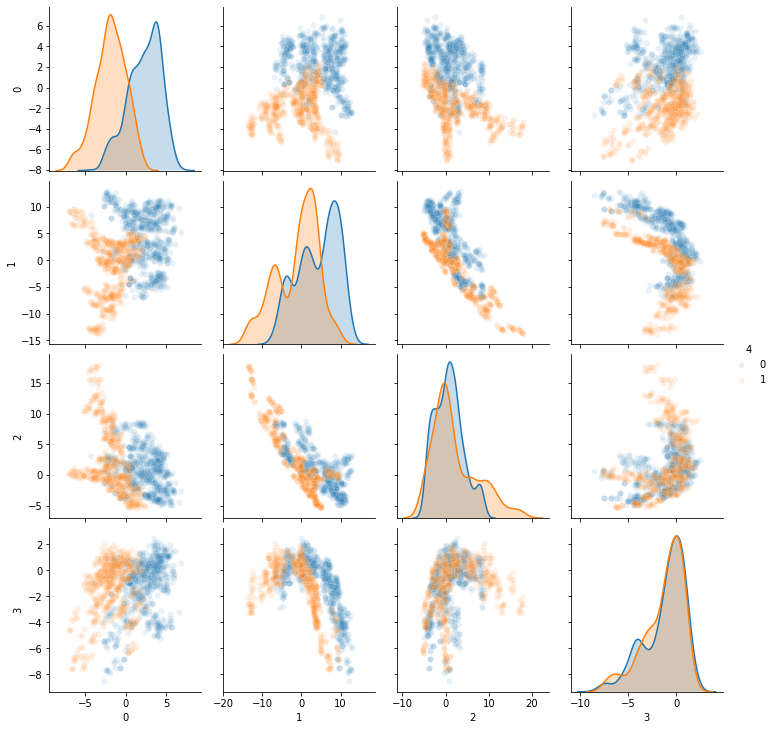

In [269]:
sns.pairplot(data, hue=4, plot_kws={'alpha': 0.1})

### Train/test split

Use an initial 80/20 train/test split, then proceed to 5-fold CV. 

In [5]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42, stratify=t)

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [7]:
t_train, t_test = t_train.values, t_test.values

#### Note on train/test split vs. cross-validation
Going from a train-test split to cross-validation seems arbitrary to me, so I'll go with both throughout (train-test split to show learning or lackthereof within a training run) instead for hyperparameter selection.

###  Dummy class ("one-hot") encoding
Appears to be unnecessary: see e.g. https://www.tensorflow.org/tutorials/keras/classification.

# Keras sequential model for classification

Implement a classifier with 2 dense hidden layers and a dropout layer before the final softmax output layer, something like this:  
Input -> Hidden -> Hidden -> Dropout -> Softmax

Start with a dropout ratio of 0.25, Adadelta as optimizer, and 10 epochs of training.

**Note:** I run most of the following multiple times (more than reflected in spreadsheet), so the associated remarks aren't based on what may just be flukes.

## Model builder

In [9]:
def get_model(n_layers, layer_sizes, activations, loss, optimizer, metrics, dropout=None, input_dropout=None):
    model = keras.Sequential()
    if dropout is None:
        dropout = [None] * n_layers
    if input_dropout:
        model.add(layers.Dropout(input_dropout))
    for i in range(n_layers):
        model.add(layers.Dense(layer_sizes[i], activation=activations[i]))
        if dropout[i]:
            model.add(layers.Dropout(dropout[i]))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

**Note:** 
1. Calling this from per-model "constructors" instead of directly because the workaround for an error-free workflow with its args passed to KerasClassifier() is ugly.
2. Also, I didn't check very carefully, but there seems to be no way to access the model model constructed and wrapped by KerasClassifier(), so the models (NNs) used for train/test and CV are distinct.

## Without dropout

In [447]:
def baseline_model():
    return get_model(3, [10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'])

In [533]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.54909092 0.55474454 0.55474454 0.44525549]
Accuracy: 50.95% (5.32%)


In [534]:
model = baseline_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 1s 1ms/sample - loss: 0.9979 - accuracy: 0.5552 - val_loss: 0.9930 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 205us/sample - loss: 0.9976 - accuracy: 0.5552 - val_loss: 0.9927 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 172us/sample - loss: 0.9974 - accuracy: 0.5552 - val_loss: 0.9925 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 177us/sample - loss: 0.9972 - accuracy: 0.5552 - val_loss: 0.9923 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 196us/sample - loss: 0.9969 - accuracy: 0.5552 - val_loss: 0.9920 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 185us/sample - loss: 0.9967 - accuracy: 0.5552 - val_loss: 0.9918 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 1s 487us/sa

**Remarks:** Train/test and CV results are similar. They stink. Not only is accuracy low, it doesn't even improve from the first epoch to the last.

## With dropout

### In 2nd hidden layer: dropout ratio 0.25

In [535]:
def basic_dropout_model():
    return get_model(3, [10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [536]:
estimator = KerasClassifier(build_fn=basic_dropout_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.55636364 0.44525549 0.48175183 0.44525549]
Accuracy: 47.45% (4.34%)


In [537]:
model = basic_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7045 - accuracy: 0.5360 - val_loss: 0.6858 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 186us/sample - loss: 0.7198 - accuracy: 0.4986 - val_loss: 0.6858 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 217us/sample - loss: 0.7021 - accuracy: 0.5606 - val_loss: 0.6858 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 179us/sample - loss: 0.7071 - accuracy: 0.5351 - val_loss: 0.6857 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 186us/sample - loss: 0.7052 - accuracy: 0.5397 - val_loss: 0.6857 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 182us/sample - loss: 0.7086 - accuracy: 0.5369 - val_loss: 0.6857 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 0s 205us/sa

**Remarks:** The results are better, but they're still not good.

### In 2nd hidden layer: dropout ratio 0.4

In [454]:
def basic_dropout_model_pt4():
    return get_model(3, [10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.4, 0])

In [455]:
estimator = KerasClassifier(build_fn=basic_dropout_model_pt4, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.5090909  0.44525549 0.55474454 0.55474454]
Accuracy: 50.15% (4.95%)


In [456]:
model = basic_dropout_model_pt4()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 1s 1ms/sample - loss: 1.2271 - accuracy: 0.4448 - val_loss: 1.1855 - val_accuracy: 0.4436
Epoch 2/10
1097/1097 [==============================] - 0s 185us/sample - loss: 1.2100 - accuracy: 0.4476 - val_loss: 1.1852 - val_accuracy: 0.4436
Epoch 3/10
1097/1097 [==============================] - 0s 352us/sample - loss: 1.2016 - accuracy: 0.4448 - val_loss: 1.1850 - val_accuracy: 0.4436
Epoch 4/10
1097/1097 [==============================] - 0s 244us/sample - loss: 1.2235 - accuracy: 0.4448 - val_loss: 1.1847 - val_accuracy: 0.4436
Epoch 5/10
1097/1097 [==============================] - 0s 250us/sample - loss: 1.1889 - accuracy: 0.4448 - val_loss: 1.1844 - val_accuracy: 0.4436
Epoch 6/10
1097/1097 [==============================] - 0s 213us/sample - loss: 1.1899 - accuracy: 0.4439 - val_loss: 1.1841 - val_accuracy: 0.4436
Epoch 7/10
1097/1097 [==============================] - 0s 320us/sa

**Remarks:** The range of results here seem similarly wide to those from the architecture with dropout ratio 0.25 in the 2nd (last) hidden layer, so it's not clear if they're substantively different.

### Dropout ratio 0.2 for both hidden layers

In [457]:
def all_dropout_model():
    return get_model(3, [10, 10, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.2, 0.2, 0])

In [458]:
estimator = KerasClassifier(build_fn=all_dropout_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.28363636 0.60583943 0.37956205 0.45985401]
Accuracy: 43.45% (10.57%)


In [459]:
model = all_dropout_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 12s 11ms/sample - loss: 0.8541 - accuracy: 0.4458 - val_loss: 0.8543 - val_accuracy: 0.4436
Epoch 2/10
1097/1097 [==============================] - 0s 179us/sample - loss: 0.8597 - accuracy: 0.4467 - val_loss: 0.8542 - val_accuracy: 0.4436
Epoch 3/10
1097/1097 [==============================] - 0s 183us/sample - loss: 0.8580 - accuracy: 0.4448 - val_loss: 0.8540 - val_accuracy: 0.4436
Epoch 4/10
1097/1097 [==============================] - 0s 186us/sample - loss: 0.8604 - accuracy: 0.4467 - val_loss: 0.8539 - val_accuracy: 0.4436
Epoch 5/10
1097/1097 [==============================] - 0s 178us/sample - loss: 0.8645 - accuracy: 0.4448 - val_loss: 0.8537 - val_accuracy: 0.4436
Epoch 6/10
1097/1097 [==============================] - 0s 207us/sample - loss: 0.8517 - accuracy: 0.4458 - val_loss: 0.8536 - val_accuracy: 0.4436
Epoch 7/10
1097/1097 [==============================] - 0s 172us/

**Remarks:** The results again seem to vary widely, and it's unclear whether this architecture is substantively different.

## Using relu instead of sigmoid activation in hidden layers

In [460]:
def basic_relu_model():
    return get_model(3, [10, 10, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [461]:
estimator = KerasClassifier(build_fn=basic_relu_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.43636364 0.22909091 0.56569344 0.50729924 0.67518246]
Accuracy: 48.27% (14.90%)


In [462]:
model = basic_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.6906 - accuracy: 0.5278 - val_loss: 0.6949 - val_accuracy: 0.5491
Epoch 2/10
1097/1097 [==============================] - 0s 195us/sample - loss: 0.6937 - accuracy: 0.5232 - val_loss: 0.6947 - val_accuracy: 0.5491
Epoch 3/10
1097/1097 [==============================] - 0s 210us/sample - loss: 0.6946 - accuracy: 0.5287 - val_loss: 0.6945 - val_accuracy: 0.5491
Epoch 4/10
1097/1097 [==============================] - 0s 203us/sample - loss: 0.6969 - accuracy: 0.5251 - val_loss: 0.6944 - val_accuracy: 0.5491
Epoch 5/10
1097/1097 [==============================] - 0s 182us/sample - loss: 0.6986 - accuracy: 0.5160 - val_loss: 0.6942 - val_accuracy: 0.5491
Epoch 6/10
1097/1097 [==============================] - 0s 314us/sample - loss: 0.6942 - accuracy: 0.5141 - val_loss: 0.6940 - val_accuracy: 0.5527
Epoch 7/10
1097/1097 [==============================] - 0s 247us/sa

**Remarks:** The results are substantially better than with 2 sigmoid-activation hidden layers.

## Varying network depth & width (hidden layer numbers & sizes)

### Using sigmoid activations

In [538]:
def bigger_sigmoid_model():
    return get_model(3, [40, 20, 1], ['sigmoid'] * 3, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [539]:
estimator = KerasClassifier(build_fn=bigger_sigmoid_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.44363636 0.44363636 0.44525549 0.55474454 0.55474454]
Accuracy: 48.84% (5.42%)


In [540]:
model = bigger_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 0.7107 - accuracy: 0.5269 - val_loss: 0.6934 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 184us/sample - loss: 0.7072 - accuracy: 0.5542 - val_loss: 0.6933 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 199us/sample - loss: 0.7208 - accuracy: 0.5314 - val_loss: 0.6932 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 230us/sample - loss: 0.7095 - accuracy: 0.5479 - val_loss: 0.6932 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 203us/sample - loss: 0.7076 - accuracy: 0.5324 - val_loss: 0.6931 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.7001 - accuracy: 0.5415 - val_loss: 0.6930 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 0s 183us/sa

**Remarks:** Still not substantially better than the same model with 10 units per hidden layer. Also tried (60, 20), but the gains seem small relative to the increase in model complexity.

### Using ReLu activations

In [542]:
def bigger_relu_model():
    return get_model(3, [40, 20, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [543]:
estimator = KerasClassifier(build_fn=bigger_relu_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.38545454 0.46909091 0.66423357 0.69343066 0.55474454]
Accuracy: 55.34% (11.59%)


In [544]:
model = bigger_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6929 - accuracy: 0.5552 - val_loss: 0.6860 - val_accuracy: 0.5564
Epoch 2/10
1097/1097 [==============================] - 0s 228us/sample - loss: 0.6972 - accuracy: 0.5469 - val_loss: 0.6856 - val_accuracy: 0.5564
Epoch 3/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.6986 - accuracy: 0.5506 - val_loss: 0.6853 - val_accuracy: 0.5564
Epoch 4/10
1097/1097 [==============================] - 0s 187us/sample - loss: 0.6952 - accuracy: 0.5561 - val_loss: 0.6850 - val_accuracy: 0.5564
Epoch 5/10
1097/1097 [==============================] - 0s 190us/sample - loss: 0.6978 - accuracy: 0.5606 - val_loss: 0.6847 - val_accuracy: 0.5564
Epoch 6/10
1097/1097 [==============================] - 0s 184us/sample - loss: 0.6984 - accuracy: 0.5506 - val_loss: 0.6844 - val_accuracy: 0.5564
Epoch 7/10
1097/1097 [==============================] - 0s 232us/sa

In [545]:
def medium_relu_model():
    return get_model(3, [20, 20, 1], ['relu', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [546]:
estimator = KerasClassifier(build_fn=medium_relu_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.43636364 0.42909092 0.41240877 0.60948902 0.59489053]
Accuracy: 49.64% (8.68%)


In [547]:
model = medium_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 1ms/sample - loss: 0.6775 - accuracy: 0.5880 - val_loss: 0.6916 - val_accuracy: 0.5600
Epoch 2/10
1097/1097 [==============================] - 0s 183us/sample - loss: 0.6813 - accuracy: 0.5798 - val_loss: 0.6914 - val_accuracy: 0.5600
Epoch 3/10
1097/1097 [==============================] - 0s 182us/sample - loss: 0.6774 - accuracy: 0.5834 - val_loss: 0.6912 - val_accuracy: 0.5600
Epoch 4/10
1097/1097 [==============================] - 0s 380us/sample - loss: 0.6817 - accuracy: 0.5962 - val_loss: 0.6910 - val_accuracy: 0.5600
Epoch 5/10
1097/1097 [==============================] - 0s 281us/sample - loss: 0.6805 - accuracy: 0.5670 - val_loss: 0.6909 - val_accuracy: 0.5600
Epoch 6/10
1097/1097 [==============================] - 0s 224us/sample - loss: 0.6738 - accuracy: 0.5962 - val_loss: 0.6907 - val_accuracy: 0.5636
Epoch 7/10
1097/1097 [==============================] - 0s 276us/sa

**Remarks:** ReLu seems to vary dramatically in performance on this dataset. Over several runs (many omitted from the spreadsheet for consistency, and including more basic (10, 10) ReLu network runs), it shows both the highest and lowest accuracies seen so far. In fact, the limited training rounds I've run may suggest its performance is declining with increasing hidden layer units, which could be an indication of overfitting.

### Using both sigmoid and ReLu activations

In [490]:
def relu_sigmoid_model():
    return get_model(3, [10, 20, 1], ['relu', 'sigmoid', 'sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0, 0.25, 0])

In [497]:
estimator = KerasClassifier(build_fn=relu_sigmoid_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.55636364 0.44363636 0.55474454 0.53649634 0.47080293]
Accuracy: 51.24% (4.64%)


In [498]:
model = relu_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 1s 1ms/sample - loss: 0.7509 - accuracy: 0.4540 - val_loss: 0.7154 - val_accuracy: 0.4073
Epoch 2/10
1097/1097 [==============================] - 0s 181us/sample - loss: 0.7490 - accuracy: 0.4439 - val_loss: 0.7153 - val_accuracy: 0.4073
Epoch 3/10
1097/1097 [==============================] - 0s 177us/sample - loss: 0.7306 - accuracy: 0.5005 - val_loss: 0.7152 - val_accuracy: 0.4073
Epoch 4/10
1097/1097 [==============================] - 0s 209us/sample - loss: 0.7433 - accuracy: 0.4768 - val_loss: 0.7152 - val_accuracy: 0.4073
Epoch 5/10
1097/1097 [==============================] - 0s 231us/sample - loss: 0.7354 - accuracy: 0.4603 - val_loss: 0.7151 - val_accuracy: 0.4073
Epoch 6/10
1097/1097 [==============================] - 0s 208us/sample - loss: 0.7392 - accuracy: 0.4795 - val_loss: 0.7150 - val_accuracy: 0.4073
Epoch 7/10
1097/1097 [==============================] - 0s 182us/sa

**Remarks:** This seems to be one of the most consistent of the networks tried, but again that's not obvious, and may be due to chance.

### Deeper sigmoid network

In [558]:
def deeper_sigmoid_model():
    return get_model(3, [10, 10, 10, 1], ['sigmoid'] * 4, 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0])

In [565]:
estimator = KerasClassifier(build_fn=deeper_sigmoid_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.51163638 0.49490911 0.49671531 0.48905116 0.48576644]
Accuracy: 49.56% (0.89%)


In [564]:
model = deeper_sigmoid_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 1ms/sample - loss: 2.3246 - accuracy: 0.5001 - val_loss: 0.7176 - val_accuracy: 0.4887
Epoch 2/10
1097/1097 [==============================] - 0s 186us/sample - loss: 2.3827 - accuracy: 0.4871 - val_loss: 0.7176 - val_accuracy: 0.4887
Epoch 3/10
1097/1097 [==============================] - 0s 186us/sample - loss: 2.2876 - accuracy: 0.4972 - val_loss: 0.7176 - val_accuracy: 0.4887
Epoch 4/10
1097/1097 [==============================] - 0s 186us/sample - loss: 2.4166 - accuracy: 0.4893 - val_loss: 0.7175 - val_accuracy: 0.4887
Epoch 5/10
1097/1097 [==============================] - 0s 211us/sample - loss: 2.3539 - accuracy: 0.4924 - val_loss: 0.7175 - val_accuracy: 0.4887
Epoch 6/10
1097/1097 [==============================] - 0s 190us/sample - loss: 2.4005 - accuracy: 0.4888 - val_loss: 0.7175 - val_accuracy: 0.4887
Epoch 7/10
1097/1097 [==============================] - 0s 181us/sa

### Deeper ReLu network

In [557]:
def deeper_relu_model():
    return get_model(3, [10, 10, 10, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0])

In [554]:
estimator = KerasClassifier(build_fn=deeper_relu_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.40981823 0.53672731 0.44051096 0.53284675 0.510584  ]
Accuracy: 48.61% (5.15%)


In [553]:
model = deeper_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 2s 2ms/sample - loss: 4.7007 - accuracy: 0.5838 - val_loss: 3.8548 - val_accuracy: 0.5902
Epoch 2/10
1097/1097 [==============================] - 0s 357us/sample - loss: 4.7214 - accuracy: 0.5840 - val_loss: 3.8410 - val_accuracy: 0.5902
Epoch 3/10
1097/1097 [==============================] - 0s 423us/sample - loss: 4.7007 - accuracy: 0.5814 - val_loss: 3.8319 - val_accuracy: 0.5902
Epoch 4/10
1097/1097 [==============================] - 0s 185us/sample - loss: 4.6080 - accuracy: 0.5855 - val_loss: 3.8199 - val_accuracy: 0.5902
Epoch 5/10
1097/1097 [==============================] - 0s 223us/sample - loss: 4.7059 - accuracy: 0.5799 - val_loss: 3.8119 - val_accuracy: 0.5902
Epoch 6/10
1097/1097 [==============================] - 0s 205us/sample - loss: 4.5992 - accuracy: 0.5842 - val_loss: 3.8044 - val_accuracy: 0.5902
Epoch 7/10
1097/1097 [==============================] - 0s 185us/sa

### Remarks on results so far
Overall, using sigmoid activation gives lower accuracies as well as variance, though dropout mitigates variance considerably in the case of ReLu. Going by the last two networks, using ReLu or a combination, along with dropout in most/all pre-output layers, seems to be a good move.

### Deeper ReLu network with dropout ratio 0.2 for input layer

In [567]:
def input_dropout_relu_model():
    return get_model(3, [10, 10, 10, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25, 0.25, 0.25, 0], input_dropout=0.2)

In [574]:
estimator = KerasClassifier(build_fn=input_dropout_relu_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.50618184 0.47890908 0.54963499 0.48175183 0.53394163]
Accuracy: 51.01% (2.80%)


In [575]:
model = input_dropout_relu_model()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=10) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 3s 3ms/sample - loss: 4.7535 - accuracy: 0.5686 - val_loss: 3.3144 - val_accuracy: 0.6135
Epoch 2/10
1097/1097 [==============================] - 0s 212us/sample - loss: 4.8019 - accuracy: 0.5641 - val_loss: 3.3143 - val_accuracy: 0.6135
Epoch 3/10
1097/1097 [==============================] - 0s 194us/sample - loss: 4.7216 - accuracy: 0.5715 - val_loss: 3.3143 - val_accuracy: 0.6135
Epoch 4/10
1097/1097 [==============================] - 0s 229us/sample - loss: 4.8082 - accuracy: 0.5705 - val_loss: 3.3143 - val_accuracy: 0.6135
Epoch 5/10
1097/1097 [==============================] - 0s 275us/sample - loss: 4.7734 - accuracy: 0.5747 - val_loss: 3.3142 - val_accuracy: 0.6135
Epoch 6/10
1097/1097 [==============================] - 0s 204us/sample - loss: 4.6789 - accuracy: 0.5756 - val_loss: 3.3142 - val_accuracy: 0.6135
Epoch 7/10
1097/1097 [==============================] - 0s 186us/sa

**Remarks:** Adding dropout for the input layer while keeping all other hyperparameters the same appears to hurt performance, maybe because the amount of exploitable information decreases overall, in the absence of an increased number of units in the hidden layers.

## Varying all of the above

### Deeper, wider ReLu network with dropout ratio 0.2 for input layer

In [83]:
def relu_model_1():
    return get_model(3, [20, 20, 20, 1], ['relu'] * 3 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.5, 0.5, 0.5, 0], input_dropout=0.2)

In [84]:
estimator = KerasClassifier(build_fn=relu_model_1, epochs=15, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.48872724 0.54563636 0.5109489  0.41277376 0.43613133]
Accuracy: 47.88% (4.85%)


In [85]:
model = relu_model_1()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=15) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/15
1097/1097 [==============================] - 2s 1ms/sample - loss: 5.8052 - accuracy: 0.5512 - val_loss: 4.0204 - val_accuracy: 0.5496
Epoch 2/15
1097/1097 [==============================] - 0s 185us/sample - loss: 5.8863 - accuracy: 0.5475 - val_loss: 4.0203 - val_accuracy: 0.5496
Epoch 3/15
1097/1097 [==============================] - 0s 193us/sample - loss: 5.9162 - accuracy: 0.5487 - val_loss: 4.0202 - val_accuracy: 0.5496
Epoch 4/15
1097/1097 [==============================] - 0s 392us/sample - loss: 5.7903 - accuracy: 0.5509 - val_loss: 4.0201 - val_accuracy: 0.5496
Epoch 5/15
1097/1097 [==============================] - 0s 235us/sample - loss: 5.9165 - accuracy: 0.5470 - val_loss: 4.0200 - val_accuracy: 0.5496
Epoch 6/15
1097/1097 [==============================] - 1s 521us/sample - loss: 5.9082 - accuracy: 0.5463 - val_loss: 4.0199 - val_accuracy: 0.5496
Epoch 7/15
1097/1097 [==============================] - 1s 524us/sa

**Remarks:** I tried so many variations on this (# units, dropout ratios), none of which seemed all that different from the rest. In the end I just semi-randomly picked something that seemed _maybe_ better.

### "Sandwich" model: 2 ReLus followed by 1 sigmoid-activated hidden layer

In [87]:
def sandwich_model_1():
    return get_model(3, [10, 10, 10, 1], ['relu', 'relu', 'sigmoid', 'sigmoid'], 'binary_crossentropy', 'Adadelta',
                     ['accuracy'], dropout=[0.25, 0.25, 0.25, 0])

In [88]:
estimator = KerasClassifier(build_fn=sandwich_model_1, epochs=15, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.51054549 0.57236362 0.4813869  0.63394165 0.50875914]
Accuracy: 54.14% (5.50%)


In [89]:
model = sandwich_model_1()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=15) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/15
1097/1097 [==============================] - 2s 2ms/sample - loss: 2.6384 - accuracy: 0.4680 - val_loss: 0.7178 - val_accuracy: 0.4705
Epoch 2/15
1097/1097 [==============================] - 0s 164us/sample - loss: 2.5675 - accuracy: 0.4720 - val_loss: 0.7178 - val_accuracy: 0.4709
Epoch 3/15
1097/1097 [==============================] - 0s 160us/sample - loss: 2.5555 - accuracy: 0.4742 - val_loss: 0.7178 - val_accuracy: 0.4709
Epoch 4/15
1097/1097 [==============================] - 0s 195us/sample - loss: 2.6088 - accuracy: 0.4724 - val_loss: 0.7178 - val_accuracy: 0.4705
Epoch 5/15
1097/1097 [==============================] - 0s 166us/sample - loss: 2.5048 - accuracy: 0.4773 - val_loss: 0.7178 - val_accuracy: 0.4709
Epoch 6/15
1097/1097 [==============================] - 0s 199us/sample - loss: 2.5711 - accuracy: 0.4672 - val_loss: 0.7178 - val_accuracy: 0.4713
Epoch 7/15
1097/1097 [==============================] - 0s 156us/sa

### 4-hidden-layer ReLu network with dropout ratio 0.2 for input layer

In [90]:
def relu_model_4hlayers():
    return get_model(3, [10] * 4 + [1], ['relu'] * 4 + ['sigmoid'], 'binary_crossentropy', 'Adadelta', ['accuracy'],
                     dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [91]:
estimator = KerasClassifier(build_fn=relu_model_4hlayers, epochs=15, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.53163642 0.46872732 0.52773726 0.5182482  0.52810216]
Accuracy: 51.49% (2.35%)


In [92]:
model = relu_model_4hlayers()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=15) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/15
1097/1097 [==============================] - 2s 2ms/sample - loss: 5.5167 - accuracy: 0.5346 - val_loss: 4.8457 - val_accuracy: 0.5564
Epoch 2/15
1097/1097 [==============================] - 0s 199us/sample - loss: 5.4475 - accuracy: 0.5308 - val_loss: 4.8455 - val_accuracy: 0.5564
Epoch 3/15
1097/1097 [==============================] - ETA: 0s - loss: 5.4099 - accuracy: 0.53 - 0s 183us/sample - loss: 5.4786 - accuracy: 0.5299 - val_loss: 4.8453 - val_accuracy: 0.5564
Epoch 4/15
1097/1097 [==============================] - 0s 163us/sample - loss: 5.5449 - accuracy: 0.5230 - val_loss: 4.8452 - val_accuracy: 0.5564
Epoch 5/15
1097/1097 [==============================] - 0s 164us/sample - loss: 5.4870 - accuracy: 0.5338 - val_loss: 4.8451 - val_accuracy: 0.5564
Epoch 6/15
1097/1097 [==============================] - 0s 159us/sample - loss: 5.4473 - accuracy: 0.5270 - val_loss: 4.8450 - val_accuracy: 0.5564
Epoch 7/15
1097/1097 [===

**Remarks:** More of the same. Sigh.

### "Sandwich" model 2: ReLu, sigmoid, ReLu hidden layers

In [165]:
def sandwich_model_2():
    return get_model(3, [20, 20, 20, 1], ['relu', 'sigmoid', 'relu', 'sigmoid'], 'binary_crossentropy', 'Adadelta',
                     ['accuracy'], dropout=[0.25, 0.25, 0.25, 0], input_dropout=0.2)

In [166]:
estimator = KerasClassifier(build_fn=sandwich_model_2, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.53272724 0.57854539 0.53941607 0.55675179 0.50894165]
Accuracy: 54.33% (2.34%)


In [167]:
model = sandwich_model_2()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 1ms/sample - loss: 5.3756 - accuracy: 0.5465 - val_loss: 4.1855 - val_accuracy: 0.5535
Epoch 2/20
1097/1097 [==============================] - 0s 116us/sample - loss: 5.3983 - accuracy: 0.5452 - val_loss: 4.1846 - val_accuracy: 0.5535
Epoch 3/20
1097/1097 [==============================] - 0s 145us/sample - loss: 5.3888 - accuracy: 0.5460 - val_loss: 4.1826 - val_accuracy: 0.5536
Epoch 4/20
1097/1097 [==============================] - 0s 136us/sample - loss: 5.3688 - accuracy: 0.5454 - val_loss: 4.1799 - val_accuracy: 0.5538
Epoch 5/20
1097/1097 [==============================] - 0s 189us/sample - loss: 5.4286 - accuracy: 0.5443 - val_loss: 4.1790 - val_accuracy: 0.5538
Epoch 6/20
1097/1097 [==============================] - 0s 146us/sample - loss: 5.4087 - accuracy: 0.5474 - val_loss: 4.1778 - val_accuracy: 0.5538
Epoch 7/20
1097/1097 [==============================] - 0s 117us/sa

**Remarks:** FINALLY, SOMETHING CLEARLY WORKS BETTER THAN THE REST. NOT BY A WHOLE LOT, BUT A BIT MORE CONSISTENTLY. (I tried 3 similar models; this seems to work marginally better than the others.)

### "Sandwich" model 3: 4 alternating ReLu-sigmoid hidden layers

In [213]:
def sandwich_model_3():
    return get_model(3, [20] * 4 + [1], ['relu', 'sigmoid', 'relu', 'relu', 'sigmoid'], 'binary_crossentropy',
                     'Adadelta', ['accuracy'], dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [214]:
estimator = KerasClassifier(build_fn=sandwich_model_3, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.53927273 0.55381817 0.50930655 0.54379565 0.55456209]
Accuracy: 54.02% (1.65%)


In [215]:
model = sandwich_model_3()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 5.3199 - accuracy: 0.5422 - val_loss: 4.5537 - val_accuracy: 0.5436
Epoch 2/20
1097/1097 [==============================] - 0s 150us/sample - loss: 5.3343 - accuracy: 0.5392 - val_loss: 4.5530 - val_accuracy: 0.5436
Epoch 3/20
1097/1097 [==============================] - 0s 222us/sample - loss: 5.2979 - accuracy: 0.5429 - val_loss: 4.5527 - val_accuracy: 0.5436
Epoch 4/20
1097/1097 [==============================] - 0s 144us/sample - loss: 5.2879 - accuracy: 0.5412 - val_loss: 4.5523 - val_accuracy: 0.5436
Epoch 5/20
1097/1097 [==============================] - 0s 234us/sample - loss: 5.3328 - accuracy: 0.5414 - val_loss: 4.5510 - val_accuracy: 0.5436
Epoch 6/20
1097/1097 [==============================] - 0s 155us/sample - loss: 5.2604 - accuracy: 0.5428 - val_loss: 4.5506 - val_accuracy: 0.5436
Epoch 7/20
1097/1097 [==============================] - 0s 139us/sa

**Remarks:** This buys a small improvement over the last model for not too much added complexity, so taking this forward. (Also tried relu-sigmoid-relu-sigmoid-relu, but the improvement is negligible.)

## With other activation functions

I could try other activations, e.g. softplus and elu, but after a day, it doesn't seem worth caring anymore.

## With other optimisers

In [235]:
def sandwich_model_rmsprop():
    return get_model(3, [20] * 4 + [1], ['relu', 'sigmoid', 'relu', 'relu', 'sigmoid'], 'binary_crossentropy',
                     'RMSprop', ['accuracy'], dropout=[0.25] * 4 + [0], input_dropout=0.2)

In [236]:
estimator = KerasClassifier(build_fn=sandwich_model_rmsprop, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, x.values, t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.78709084 0.77581817 0.67609495 0.6614964  0.68412411]
Accuracy: 71.69% (5.33%)


**Remarks: **I can't believe this. Guess I'm calling it a day now, and letting other improvements I may have missed go.

In [237]:
model = sandwich_model_rmsprop()
model.fit(x_train, t_train, validation_data=(x_test, t_test), epochs=20, batch_size=64) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 5.0241 - accuracy: 0.5481 - val_loss: 3.5854 - val_accuracy: 0.5540
Epoch 2/20
1097/1097 [==============================] - 0s 169us/sample - loss: 4.6482 - accuracy: 0.5465 - val_loss: 3.2947 - val_accuracy: 0.5756
Epoch 3/20
1097/1097 [==============================] - 0s 331us/sample - loss: 4.3585 - accuracy: 0.5466 - val_loss: 2.9265 - val_accuracy: 0.5640
Epoch 4/20
1097/1097 [==============================] - 0s 160us/sample - loss: 4.1881 - accuracy: 0.5545 - val_loss: 2.3928 - val_accuracy: 0.5642
Epoch 5/20
1097/1097 [==============================] - 0s 136us/sample - loss: 4.0162 - accuracy: 0.5444 - val_loss: 2.0322 - val_accuracy: 0.5635
Epoch 6/20
1097/1097 [==============================] - 0s 135us/sample - loss: 3.9218 - accuracy: 0.5492 - val_loss: 1.7852 - val_accuracy: 0.5676
Epoch 7/20
1097/1097 [==============================] - 0s 137us/sa

### With normalised data

Turns out I normalised the data but forgot to use it for train/test splits. Thankfully, the features seem to be on very similar scales, so that may not be an issue at all. Regardless, I suppose I should repeat the last exercise with normalised data (and use raw data instead for the train/test split) to at least see how different the results may be.

In [246]:
estimator = KerasClassifier(build_fn=sandwich_model_rmsprop, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, StandardScaler().fit_transform(x), t.values, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.6334545  0.58072734 0.57956201 0.58576643 0.60748178]
Accuracy: 59.74% (2.07%)


Since I was so economical in allocating/naming variables, I'll be lazy and use a different split instead of computing the raw data from the standardised...

In [240]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42, stratify=t)

In [247]:
model = sandwich_model_rmsprop()
model.fit(x_train.values, t_train.values, validation_data=(x_test.values, t_test.values),
          epochs=20, batch_size=64) # default batch size: 32

Train on 1097 samples, validate on 275 samples
Epoch 1/20
1097/1097 [==============================] - 2s 2ms/sample - loss: 5.0051 - accuracy: 0.5234 - val_loss: 2.9809 - val_accuracy: 0.5169
Epoch 2/20
1097/1097 [==============================] - 0s 134us/sample - loss: 4.7866 - accuracy: 0.5274 - val_loss: 2.7074 - val_accuracy: 0.5440
Epoch 3/20
1097/1097 [==============================] - 0s 153us/sample - loss: 4.5425 - accuracy: 0.5325 - val_loss: 2.5043 - val_accuracy: 0.5525
Epoch 4/20
1097/1097 [==============================] - 0s 155us/sample - loss: 4.4317 - accuracy: 0.5325 - val_loss: 2.3025 - val_accuracy: 0.5542
Epoch 5/20
1097/1097 [==============================] - 0s 139us/sample - loss: 4.3553 - accuracy: 0.5294 - val_loss: 2.1805 - val_accuracy: 0.5616
Epoch 6/20
1097/1097 [==============================] - 0s 143us/sample - loss: 4.2269 - accuracy: 0.5423 - val_loss: 1.9860 - val_accuracy: 0.5622
Epoch 7/20
1097/1097 [==============================] - 0s 136us/sa

**Remarks:** Interestingly, accuracy is obviously considerably lower using normalised data for training, evaluated using 5-fold CV. When I was starting on this assignment, I didn't think that would be the case, since normalisation is merely a linear transformation of each feature. However, as I realised after the last training runs, since the features are normalised _individually_, that could distort the _joint_ distributions of the feature values, perhaps resulting in a loss of valuable information that would explain this behaviour.

## Conclusion
Highest-accuracy network (# units and dropout ratios parenthesised):  
Input (20, 0.2) -> ReLu (20, 0.25) -> Sigmoid (20, 0.25) -> ReLu (20, 0.25) -> ReLu (20, 0.25) -> Sigmoid (1, 0)  
Optimiser: RMSprop  
**Note:** This result only holds using raw data.

In [251]:
print('Mean 5-fold CV accuracy over 4 rounds of training: %.2f%%' % ((69.94 + 73.65 + 73.66 + 73.78) / 4))

Mean 5-fold CV accuracy over 4 rounds of training: 72.76%
